In [1]:
import csv
import os

ORDERS_PATH = "data/processed/train_reordered_pairs_gpt5_nano_numeric.csv"
SHUFFLED_PATH = "data/processed/train_processed.csv"
OUTPUT_PATH = "data/processed/train_gpt5_nano_reordered.csv"


def apply_order_to_shuffled(shuffled_story: str, order_str: str) -> str:
    sentences = [s.strip() for s in shuffled_story.split("|")]
    digits = [ch for ch in order_str if ch.isdigit()]

    if len(digits) != len(sentences):
        pass

    reordered = []
    for d in digits:
        idx = int(d) - 1
        if 0 <= idx < len(sentences):
            reordered.append(sentences[idx])
        else:
            reordered.append(f"[INDEX_OUT_OF_RANGE_{d}]")

    return " | ".join(reordered)


def main():
    orders = []

    with open(ORDERS_PATH, "r", newline="", encoding="utf-8") as f_orders:
        reader = csv.DictReader(f_orders)
        for row in reader:
            order_str = row["reordered_story"].strip()
            orders.append(order_str)

    with open(SHUFFLED_PATH, "r", newline="", encoding="utf-8") as f_in, \
         open(OUTPUT_PATH, "w", newline="", encoding="utf-8") as f_out:

        reader = csv.DictReader(f_in)
        writer = csv.writer(f_out, quoting=csv.QUOTE_ALL)

        writer.writerow(["story_id", "gold", "shuffled", "model_reordered"])

        for row in reader:
            story_id = int(row["story_id"])
            gold = row["gold"]
            shuffled = row["shuffled"]

            if story_id >= len(orders):
                continue

            order_str = orders[story_id]

            model_reordered = apply_order_to_shuffled(shuffled, order_str)

            writer.writerow([story_id, gold, shuffled, model_reordered])
            f_out.flush()
            os.fsync(f_out.fileno())


if __name__ == "__main__":
    main()


In [2]:
from accuracy_calculations import compute_kendall_tau
from accuracy_calculations import compute_pmr

# GPT-5 Nano
gpt_5_nano_pmr, gpt_5_nano_matches, gpt5_nano_total = compute_pmr("data/final_outputs/train_gpt5_nano_reordered.csv")
gpt5_nano_taus, gpt5_nano_out_of_range_count, gpt5_nano_wrong_num_sentences_count = compute_kendall_tau("data/final_outputs/train_gpt5_nano_reordered.csv")
print("gpt5 nano PMR: ", gpt_5_nano_pmr)
print("Average gpt5 nano Kendall tau:", sum(gpt5_nano_taus)/len(gpt5_nano_taus))
print("gpt5 nano index out of range count: ", gpt5_nano_out_of_range_count)
print("gpt5 nano wrong number of sentences predicted count: ", gpt5_nano_wrong_num_sentences_count)
print(f"\n")

# LLaMA-3
llama3_pmr, llama3_matches, llama3_total = compute_pmr("data/final_outputs/train_llama3_reordered.csv")
llama3_taus, llama3_out_of_range_count, llama3_wrong_num_sentences_count = compute_kendall_tau("data/final_outputs/train_llama3_reordered.csv")
print("llama3 PMR: ", llama3_pmr)
print("Average llama3 Kendall tau:", sum(llama3_taus)/len(llama3_taus))
print("llama3 index out of range count: ", llama3_out_of_range_count)
print("llama3 wrong number of sentences predicted count: ", llama3_wrong_num_sentences_count)
print(f"\n")

# Qwen
qwen_pmr, qwen_matches, qwen_total = compute_pmr("data/final_outputs/train_qwen_reordered.csv")
qwen_taus, qwen_out_of_range_count, qwen_wrong_num_sentences_count = compute_kendall_tau("data/final_outputs/train_qwen_reordered.csv")
print("qwen PMR: ", qwen_pmr)
print("Average qwen Kendall tau:", sum(qwen_taus)/len(qwen_taus))
print("qwen index out of range count: ", qwen_out_of_range_count)
print("qwen wrong number of sentences predicted count: ", qwen_wrong_num_sentences_count)
print(f"\n")

# Overall
overall_pmr = (gpt_5_nano_matches + llama3_matches + qwen_matches) / (gpt5_nano_total + llama3_total + qwen_total)
all_taus = gpt5_nano_taus + llama3_taus + qwen_taus
overall_avg_tau = sum(all_taus) / len(all_taus)
total_out_of_range_count = gpt5_nano_out_of_range_count + llama3_out_of_range_count + qwen_out_of_range_count
total_wrong_num_sentences_count = gpt5_nano_wrong_num_sentences_count + llama3_wrong_num_sentences_count + qwen_wrong_num_sentences_count
print("Overall PMR acorss all models: ", overall_pmr)
print("Overall average Kendall tau across all models: ", overall_avg_tau)
print("Total index out of range count across all models: ", total_out_of_range_count)
print("Total wrong number of sentences count across all models: ", total_wrong_num_sentences_count)


gpt5 nano PMR:  0.4321340964840556
Average gpt5 nano Kendall tau: 0.7252657399836401
gpt5 nano index out of range count:  0
gpt5 nano wrong number of sentences predicted count:  0


llama3 PMR:  0.041155329593267884
Average llama3 Kendall tau: 0.3449333800841569
llama3 index out of range count:  11
llama3 wrong number of sentences predicted count:  24


qwen PMR:  0.5889839806890498
Average qwen Kendall tau: 0.8360763660302925
qwen index out of range count:  0
qwen wrong number of sentences predicted count:  1


Overall PMR acorss all models:  0.08691733707969411
Overall average Kendall tau across all models:  0.38692661462405237
Total index out of range count across all models:  11
Total wrong number of sentences count across all models:  25


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = {
    'Model': ['GPT-5 Nano', 'LLaMA-3', 'Qwen'],
    'PMR': [0.4321340964840556, 0.041155329593267884, 0.5889839806890498],
    'Kendall_Tau': [0.7252657399836401, 0.3449333800841569, 0.8360763660302925],
    'Out_Of_Range_Count': [0, 11, 0],
    'Wrong_Num_Sentences_Count': [0, 24, 1]
}

df = pd.DataFrame(data)

csv_file_path = 'model_accuracy_summary.csv'
df.to_csv(csv_file_path, index=False)

plt.figure(figsize=(10, 6))
bar_width = 0.35
r1 = np.arange(len(df['Model']))
r2 = [x + bar_width for x in r1]
plt.bar(r1, df['PMR'], color='skyblue', width=bar_width, edgecolor='grey', label='PMR')
plt.bar(r2, df['Kendall_Tau'], color='lightcoral', width=bar_width, edgecolor='grey', label='Average Kendall $\\tau$')
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(df['Model']))], df['Model'])
plt.title('Model Performance: PMR vs. Average Kendall $\\tau$', fontweight='bold')
plt.legend()
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('performance_metrics_comparison.png')
plt.close()
plt.figure(figsize=(10, 6))
bar_width = 0.35
r1 = np.arange(len(df['Model']))
r2 = [x + bar_width for x in r1]
plt.bar(r1, df['Out_Of_Range_Count'], color='mediumseagreen', width=bar_width, edgecolor='grey', label='Index Out of Range Count')
plt.bar(r2, df['Wrong_Num_Sentences_Count'], color='gold', width=bar_width, edgecolor='grey', label='Wrong Number of Sentences Count')
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Count of Errors', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(df['Model']))], df['Model'])
plt.title('Model Robustness: Error Counts', fontweight='bold')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('error_counts_comparison.png')
plt.close()

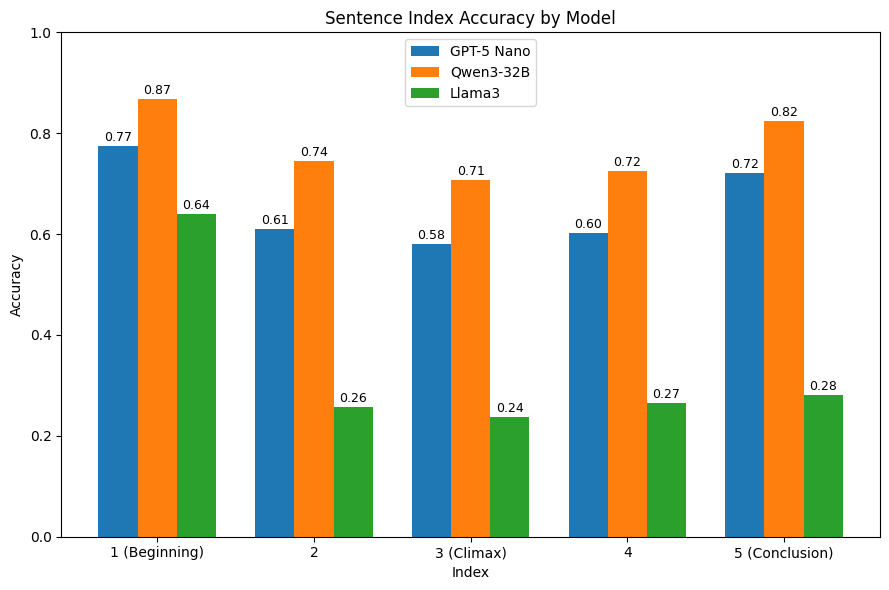

In [1]:
import numpy as np
import matplotlib.pyplot as plt

labels = ["1 (Beginning)", "2", "3 (Climax)", "4", "5 (Conclusion)"]

gpt5_nano = [0.774, 0.610, 0.581, 0.602, 0.721]
qwen3 = [0.867, 0.745, 0.708, 0.725, 0.824]
llama3 = [0.640, 0.258, 0.237, 0.266, 0.281]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(9, 6))

plt.bar(x - width, gpt5_nano, width, label="GPT-5 Nano")
plt.bar(x, qwen3, width, label="Qwen3-32B")
plt.bar(x + width, llama3, width, label="Llama3")

plt.xlabel("Index")
plt.ylabel("Accuracy")
plt.title("Sentence Index Accuracy by Model")
plt.xticks(x, labels)
plt.ylim(0, 1.0)
plt.legend()

for i in range(len(labels)):
    plt.text(x[i] - width, gpt5_nano[i] + 0.01, f"{gpt5_nano[i]:.2f}", ha="center", fontsize=9)
    plt.text(x[i], qwen3[i] + 0.01, f"{qwen3[i]:.2f}", ha="center", fontsize=9)
    plt.text(x[i] + width, llama3[i] + 0.01, f"{llama3[i]:.2f}", ha="center", fontsize=9)

plt.tight_layout()
plt.savefig("sentence_accuracy_comparison.png", dpi=200)
plt.show()
